### Setup

In [ ]:
!pip install git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.4 MB/s eta 0:00:00


In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=9379287797234b0e57cd294893f4eb9c57c1aa3a0415fe194f4ad7f0c69fa25d
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import pandas as pd
import wget
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
import tensorflow as tf
from tensorflow import keras
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization
import numpy as np

Using TensorFlow backend


### Load Data

In [ ]:
path_zip = 'https://public.roboflow.com/ds/6Fnh8IfS02?key=8iDZV73tVg'
path_save = '/content'
wget.download(path_zip, path_save)

'/content/Self Driving Car.v3-fixed-small.tensorflow.zip'

In [ ]:
!unzip '/content/Self Driving Car.v3-fixed-small.tensorflow.zip' -d '/content/data'

Streaming output truncated to the last 5000 lines.
 extracting: /content/data/export/1478900100165707353_jpg.rf.02dae94790fe0a5fd8145e6582060381.jpg  
 extracting: /content/data/export/1478900100165707353_jpg.rf.mLJlW3Cf3VoVKjXY6jgh.jpg  
 extracting: /content/data/export/1478900100737478288_jpg.rf.2bb35a1222e15394de7033687f69065c.jpg  
 extracting: /content/data/export/1478900100737478288_jpg.rf.nbrgBfnnhHP0mwGGKfnW.jpg  
 extracting: /content/data/export/1478900101309115339_jpg.rf.2508668be11307c87ff954cf21544d10.jpg  
 extracting: /content/data/export/1478900101309115339_jpg.rf.OsDb7MLdxcxdujSvvLyR.jpg  
 extracting: /content/data/export/1478900101879688623_jpg.rf.81c3be06336e0ae02178f47713d58e6f.jpg  
 extracting: /content/data/export/1478900101879688623_jpg.rf.v2nxcO0TVyrQn6VcGa1D.jpg  
 extracting: /content/data/export/1478900102451943901_jpg.rf.4kwTUlpUEj4Jc9ubppWJ.jpg  
 extracting: /content/data/export/1478900102451943901_jpg.rf.bb6b07a82d52b84fdcc5593bc581128c.jpg  
 extracti

### Prepare data

In [ ]:
path_dir = '/content/data/export/'
path_file_csv = [os.path.join(path_dir,file_name) for file_name in os.listdir(path_dir) if file_name.endswith('.csv')]

In [ ]:
len(os.listdir(path_dir))

29801

In [ ]:
df = pd.read_csv(path_file_csv[0])

In [ ]:
df.shape

(194539, 8)

In [ ]:
df.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,291,247,370,331
1,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,pedestrian,270,235,293,321
2,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,0,266,13,327
3,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,25,258,106,304
4,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,111,259,135,289
5,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,128,226,274,423
6,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,325,223,440,347
7,1478900859981702684_jpg.rf.6830635c7d919747563...,512,512,car,388,234,510,388
8,1478899488314454755_jpg.rf.68494c78e9f58ebf38e...,512,512,pedestrian,21,256,31,282
9,1478899488314454755_jpg.rf.68494c78e9f58ebf38e...,512,512,pedestrian,32,254,43,284


In [ ]:
class_id = list(df['class'].unique())
class_mapping = dict(zip(range(len(class_id)), class_id))

In [ ]:
class_mapping

{0: 'car',
 1: 'pedestrian',
 2: 'biker',
 3: 'truck',
 4: 'trafficLight-Red',
 5: 'trafficLight',
 6: 'trafficLight-Green',
 7: 'trafficLight-RedLeft',
 8: 'trafficLight-GreenLeft',
 9: 'trafficLight-Yellow',
 10: 'trafficLight-YellowLeft'}

#### Preprocess

In [ ]:
def Prepare_data(data):
  gk = data.groupby('filename')
  image_path = []
  boxes = []
  classes_id = []
  for group_name in list(gk.first().index):
    try:
      image_path.append(os.path.join(path_dir , group_name))
    except:
      continue
    group_value = gk.get_group(group_name)
    boxes.append(group_value.loc[: , ['xmin' , 'ymin' , 'xmax' , 'ymax']].values.tolist())
    classes = list(group_value['class'])
    classes_id.append([list(class_mapping.keys())[list(class_mapping.values()).index(cls)] for cls in classes])
  return image_path , boxes , classes_id

In [ ]:
image_path , boxes , classes = Prepare_data(df)

In [ ]:
bbox = tf.ragged.constant(boxes)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_path)

data = tf.data.Dataset.from_tensor_slices((image_path , classes , bbox))
data = data.take(int(len(image_paths)*0.5))

In [ ]:
config = {
    'SPLIT_RATIO' : 0.1,
    'BATCH_SIZE': 4,
    'LEARNING_RATE0' : 0.001,
    'EPOCH' : 5 ,
    'GLOBAL_CLIPNORM': 10.0
}

In [ ]:
num_val = int(len(image_paths)*config['SPLIT_RATIO'])
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [ ]:
def load_image(path_image):
  image = tf.io.read_file(path_image)
  image = tf.image.decode_jpeg(image , channels= 3)
  return image

def load_dataset(path_image , classes , bbox):
  image = load_image(path_image)
  bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": tf.cast(bbox , dtype = tf.float32),
    }
  return {'images': image , 'bounding_boxes' : bounding_boxes}

#### Data Augmentation

In [ ]:
augument = keras.Sequential(layers=[
    keras_cv.layers.RandomFlip('horizontal' , bounding_box_format= 'xyxy'),
    keras_cv.layers.RandomShear(x_factor = 0.2 , y_factor = 0.2 , bounding_box_format= 'xyxy'),
    keras_cv.layers.JitteredResize(target_size= (640 , 640) , scale_factor= (0.75 , 1.3) , bounding_box_format='xyxy')
])

In [ ]:
train_ds = train_data.map(load_dataset , num_parallel_calls= tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size= 1000 , reshuffle_each_iteration= True)
train_ds = train_ds.ragged_batch(batch_size= config['BATCH_SIZE'] , drop_remainder= True)
train_ds = train_ds.map(augument , num_parallel_calls= tf.data.AUTOTUNE)

In [ ]:
train_ds.take(1)

<_TakeDataset element_spec={'images': TensorSpec(shape=(4, 640, 640, 3), dtype=tf.float32, name=None), 'bounding_boxes': {'classes': RaggedTensorSpec(TensorShape([4, None]), tf.float32, 1, tf.int64), 'boxes': RaggedTensorSpec(TensorShape([4, None, None]), tf.float32, 1, tf.int64)}}>

In [ ]:
resize = keras_cv.layers.JitteredResize(target_size= (640 , 640 ) , scale_factor=(0.75 , 1.3) , bounding_box_format= 'xyxy')
val_ds = val_data.map(load_dataset , num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(buffer_size= 1000 , reshuffle_each_iteration= True)
val_ds = val_ds.ragged_batch(batch_size = config['BATCH_SIZE'] , drop_remainder = True)
val_ds = val_ds.map(resize , num_parallel_calls = tf.data.AUTOTUNE)

#### Visualization

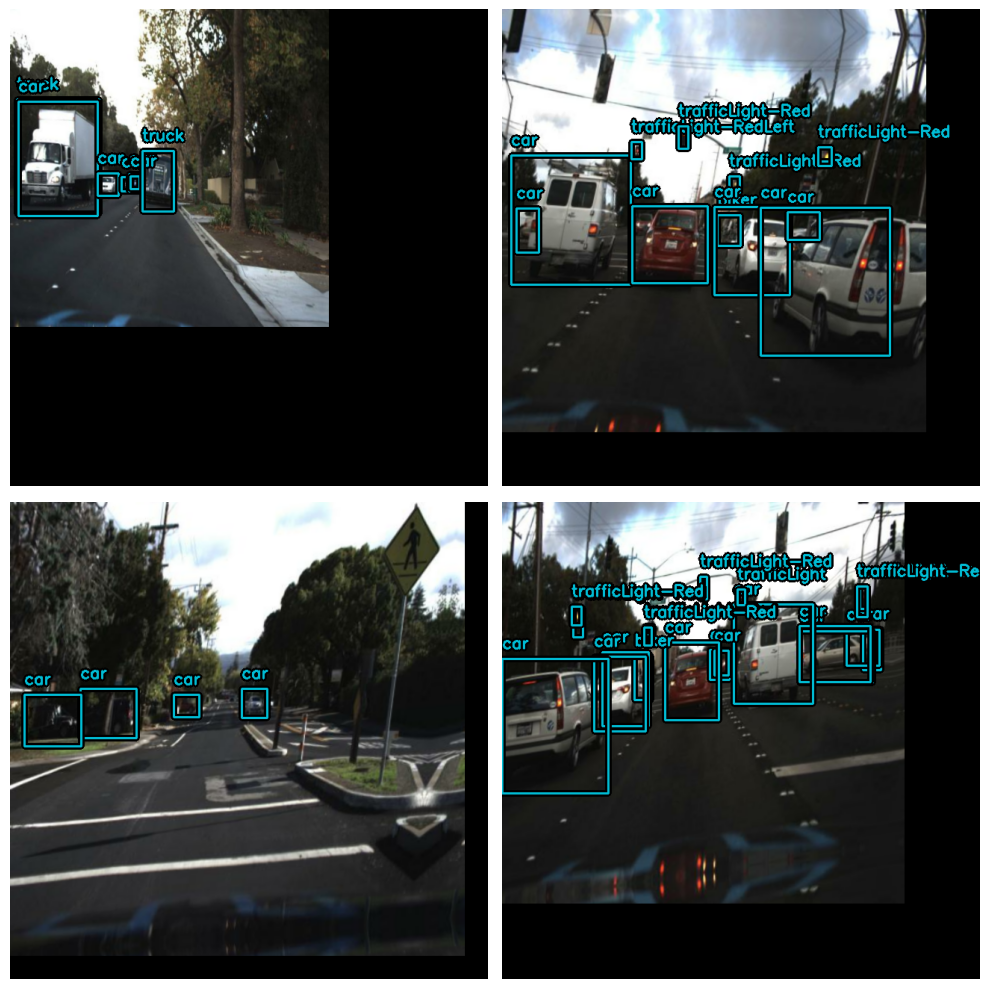

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
def dict_to_tupe(inputs):
  return inputs['images'] , inputs['bounding_boxes']

train_ds = train_ds.map(dict_to_tupe , num_parallel_calls= tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(dict_to_tupe , num_parallel_calls= tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

### Creating Model

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_s_backbone_coco")
yolo = keras_cv.models.YOLOV8Detector(backbone= backbone , num_classes= len(class_mapping) , fpn_depth = 1 , bounding_box_format= 'xyxy')

INFO:kagglehub.clients:Downloading from https://www.kaggle.com/api/v1/models/keras/yolov8/keras/yolo_v8_s_backbone_coco/2/download/config.json...
100%|██████████| 646/646 [00:00<00:00, 600kB/s]
INFO:kagglehub.clients:Downloading from https://www.kaggle.com/api/v1/models/keras/yolov8/keras/yolo_v8_s_backbone_coco/2/download/model.weights.h5...
100%|██████████| 19.7M/19.7M [00:00<00:00, 29.5MB/s]
/usr/local/lib/python3.10/dist-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._fun

In [ ]:
optimizer = tf.optimizers.Adam(learning_rate= config['LEARNING_RATE0'] , global_clipnorm = config['GLOBAL_CLIPNORM'])
yolo.compile(optimizer = optimizer , classification_loss="binary_crossentropy" , box_loss = 'ciou')

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            y_pred = bounding_box.to_dense(y_pred)
            y_true = bounding_box.to_dense(y_true)
            min_num = min(y_pred['classes'].shape[1],y_true['classes'].shape[1])
            y_pred['boxes'] = y_pred['boxes'][: , :min_num , :]
            y_pred['classes'] = y_pred['classes'][: , :min_num]
            y_pred['confidence'] = y_pred['confidence'][: , :min_num]
            y_true['boxes'] = y_true['boxes'][: , :min_num , :]
            y_true['classes'] = y_true['classes'][: , :min_num]
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [ ]:
callback  = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    restore_best_weights=True,
)

### Train model

In [ ]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    callbacks=[callback],
)

2630/2630 [==============================] - 1102s 418ms/step - loss: 1.8568 - box_loss: 1.7461 - class_loss: 0.1107 - val_loss: 2.4396 - val_box_loss: 2.2884 - val_class_loss: 0.1512


In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

1/1 [==============================] - 0s 259ms/step


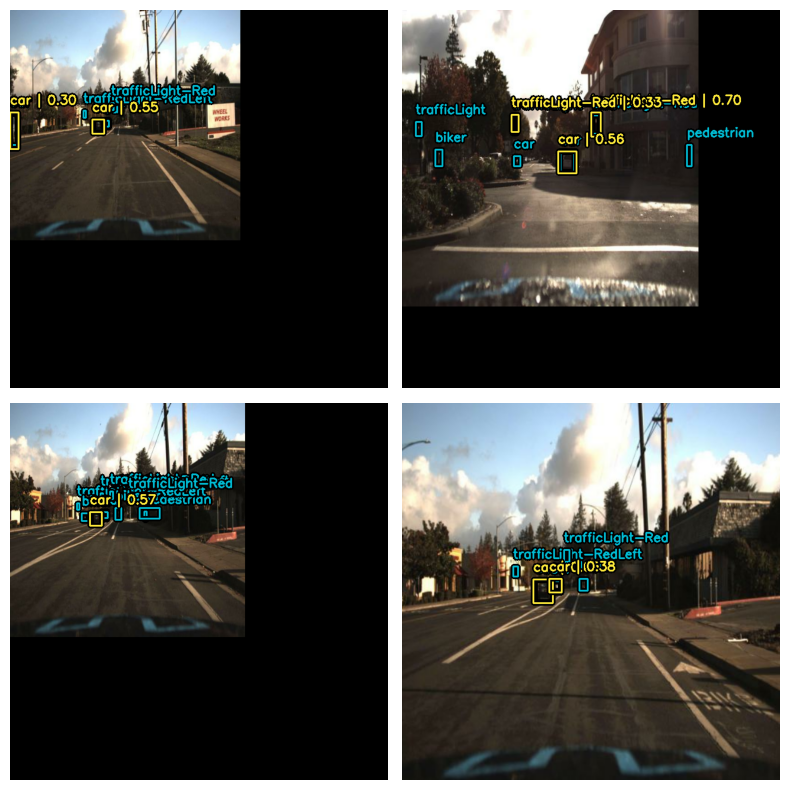

In [ ]:
visualize_detections(yolo , val_ds , 'xyxy')

In [ ]:
def load_image_test(path_image):
  image = tf.io.read_file(path_image)
  image = tf.image.decode_jpeg(image , channels= 3)
  return {'images' : image}

def dict_to_tupe_test(input):
  return input['images']

In [ ]:
resize_image = keras_cv.layers.JitteredResize(target_size= (640 , 640 ) , scale_factor=(0.75 , 1.3) , bounding_box_format= 'xyxy')

In [ ]:
path_dir = '/content/data/test'
path_file = [os.path.join(path_dir,file) for file in os.listdir(path_dir) if file.endswith('jpg')]
image_paths_test = tf.ragged.constant(path_file)
image_paths_test = tf.data.Dataset.from_tensor_slices(image_paths_test)
images_test = image_paths_test.map(load_image_test , num_parallel_calls = tf.data.AUTOTUNE)
images_test = images_test.ragged_batch(batch_size = 4 , drop_remainder = True)
images_test = images_test.map(resize_image , num_parallel_calls = tf.data.AUTOTUNE)
images_test = images_test.map(dict_to_tupe_test , num_parallel_calls = tf.data.AUTOTUNE)

### Result

1/1 [==============================] - 0s 269ms/step


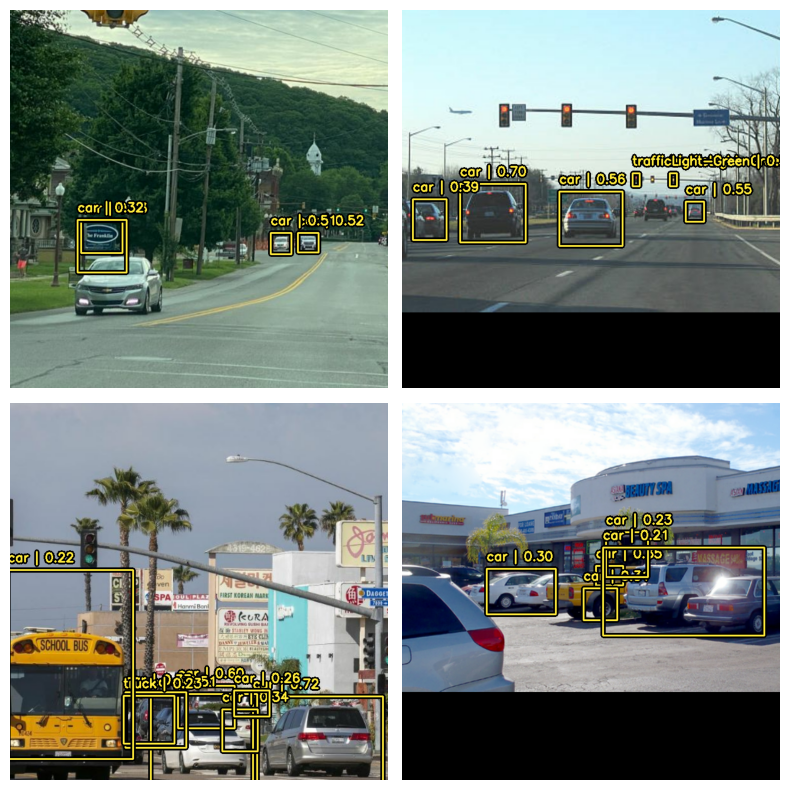

In [ ]:
images = next(iter(images_test.take(1)))
y_pred = yolo.predict(images)
y_pred = bounding_box.to_ragged(y_pred)
visualization.plot_bounding_box_gallery(
        images,
        value_range=(0,255),
        rows=2,
        cols=2,
        y_pred=y_pred,
        scale=4,
        font_scale=0.7,
        bounding_box_format='xyxy',
        class_mapping=class_mapping,
        show = True
    )